<a href="https://colab.research.google.com/github/and-rgr/contradiction_and_entailment/blob/main/dce_tut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# must enable GPU or TPU for Google Colab
# menu Runtime > Change Runtime Type

In [3]:
import tensorflow as tf

In [4]:
troubleshoot = False

if troubleshoot == True:
    python_version = !python --version
    print(python_version[0], '\n')
    print('tensorflow version: ', tf.version.VERSION, '\n')
    nvcc_version = !nvcc --version
    for i in range(len(nvcc_version)):
        print(nvcc_version[i])
    print('')
    session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
    print(session, '\n')
    gpu_device = tf.test.gpu_device_name()
    print(gpu_device, '\n')
    nvidia_smi = !nvidia-smi
    for row in nvidia_smi:
        print(row)

In [5]:
!ls

sample_data  test.csv  train.csv


In [6]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 51.7 MB/s 
     |████████████████████████████████| 3.3 MB 43.5 MB/s 
     |████████████████████████████████| 596 kB 55.9 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
# !pip install sentencepiece

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imported above
# import tensorflow as tf

# requires the sentencepiece package (unsupervised text tokenizer and detokenizer)
# from transformers import TFAutoModel,AutoTokenizer

# used for the BertTokenizer
from transformers import BertTokenizer, TFBertModel

## see the entire dataframe width in the console
pd.set_option('display.expand_frame_repr', False)

## to silence warning - what?
os.environ["WANDB_API_KEY"] = "0"

# set up the TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU

print('Number of replicas:', strategy.num_replicas_in_sync)

# see available files
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Number of replicas: 1
./train.csv
./test.csv
./.config/.last_update_check.json
./.config/gce
./.config/.last_survey_prompt.yaml
./.config/active_config
./.config/config_sentinel
./.config/.last_opt_in_prompt.yaml
./.config/logs/2022.01.07/14.32.37.114755.log
./.config/logs/2022.01.07/14.33.41.864886.log
./.config/logs/2022.01.07/14.33.42.565580.log
./.config/logs/2022.01.07/14.33.15.504888.log
./.config/logs/2022.01.07/14.33.22.232212.log
./.config/logs/2022.01.07/14.32.57.118850.log
./.config/configurations/config_default
./sample_data/README.md
./sample_data/anscombe.json
./sample_data/mnist_test.csv
./sample_data/california_housing_test.csv
./sample_data/california_housing_train.csv
./sample_data/mnist_train_small.csv


(500, 6)
(200, 5)
             id                                            premise                                         hypothesis lang_abv language  label
490  a7f4859d7b  Bunun için baktım, Ramona'nın nerede olduğunu ...                         Ben Ramona'yı önemsemedim.       tr  Turkish      2
491  4fc0edff09  As a result of the comments received, AMS chan...  The proposed rule was changed after AMS saw th...       en  English      0
492  a91386062c  Each one planting itself in the sides of Stark...                        Stark's neck was hit twice.       en  English      0
493  2238579738           We always knew it was an outside chance.  We were never assured of it happening in time ...       en  English      0
494  be4a343e63  there and they uh they in fact they had this w...  The canal is smaller than people expect it to be        en  English      0
495  8ea8763287  i also use my PC to emulate a mainframe termin...  My PC is used as an emulator for a mainframe t...       

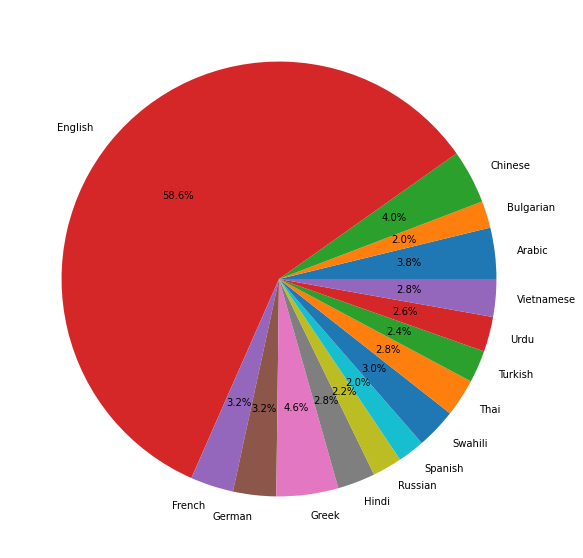

0    185
1    165
2    150
Name: label, dtype: int64


In [9]:
# load data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

# reduce data - optional
train = train.iloc[:500]
test = test.iloc[:200]


# inspect data
print(train.shape)
print(test.shape)

print(train.tail(10))
print(test.tail(10))

print(train.premise.values[1], '\n', train.hypothesis.values[1], '\n', train.label.values[1])

labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

print(train.label.value_counts())

In [17]:
# Prepare Data for Input

model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# BERT uses three kind of input data- input word IDs, input masks, and input type IDs.
# These allow the model to know that the premise and hypothesis are distinct sentences, and to ignore any padding from the tokenizer.

In [16]:
# tokenization example

def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)
   
encode_sentence("I love machine learning")

[146, 16138, 21432, 26901, 102]

In [13]:
# we add a [CLS] token to mark the beginning of inputs
# we add a [SEP] toekn to mark the separation between premise and hypothesis
# we also pad all inputs to be the same size

def bert_encode(hypotheses, premises, tokenizer):
    
    num_examples = len(hypotheses)
  
    # Constructs a constant RaggedTensor from a nested Python list
    sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}

    return inputs

In [14]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [19]:
# Create Model

# we incorporate the BERT transformer into a Keras Functional Model

def build_model(max_len = 50):
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
with strategy.scope():
    model = build_model()
    model.summary()

In [ ]:
model.fit(train_input, train.label.values, epochs = 2, verbose = 1, batch_size = 64, validation_split = 0.2)

In [ ]:
# Generate Predictions

predictions = [np.argmax(i) for i in model.predict(test_input)]

# The submission file will consist of the ID column and a prediction column.
# We can just copy the ID column from the test file, make it a dataframe, and then add our prediction column.
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

submission.to_csv("submission.csv", index = False)